In [1]:
#%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import openturns as ot
import copulogram as cp
import openturns.viewer as viewer
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from windrose import WindroseAxes
ot.RandomGenerator.SetSeed(0)

In [3]:
ot.ResourceMap.SetAsUnsignedInteger('KernelSmoothing-BinNumber', 5000)

In [4]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [5]:
N = 5000
data = pd.read_csv("./data/wind_waves_ANEMOC_1H.csv", index_col=0)
data = data.iloc[:N]
# usually the convention considers 0° for wind blowing to the north
# the convention adopted by Erik and in farmshadow is different 
# to plot correctly on the wind rose need to define a new wind direction 
data['θ_wind (deg)'] = np.mod(data['θ_wind (deg)'] - 90, 360)
data['θ_wave_new (deg)'] = np.mod(data['θ_wave_new (deg)'] - 90, 360)
sample = ot.Sample(np.array(data.values))
sample.setDescription(data.columns)

In [6]:
sample_wd = sample[:, 0]
sample_ws = sample[:, 1]
sample_wave_dir = sample[:, 2]
sample_Hs = sample[:, 3]
sample_Tp = sample[:, 4]
sample_HT = sample[:,(0,3)]

## Data visualization

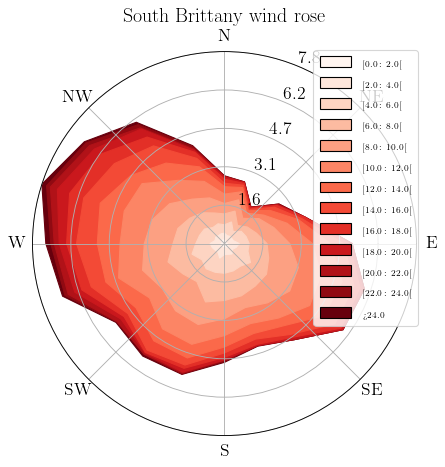

In [7]:
ax = WindroseAxes.from_ax()
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)

ax.contourf(np.array(sample_wd).flatten(), np.array(sample_ws).flatten(), normed=True, bins=np.arange(0, 26, 2), nsector=20, cmap=cm.Reds)
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], fontsize=16)
ax.set_title('South Brittany wind rose', fontsize=18)
ax.set_legend(loc='best', fontsize=14);
fig.savefig('figures/SB_wind_rose.png', bbox_inches='tight', dpi=300, transparent=True)

## Marginal distribution inference

### Wind speed

In [8]:
factory_mle_wbl3 = ot.MaximumLikelihoodFactory(ot.WeibullMin())
# Give bounds for the optimization
lowerBound=[1., 1., 0.0]
upperBound=[15.0, 3.0, 1.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_wbl3.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_mle_wbl3.getOptimizationAlgorithm()
solver.setStartingPoint([10.0, 2.0, 0.0])
# solve the distribution
fitted_ws = factory_mle_wbl3.build(sample_ws)
print(fitted_ws)
# BIC
print(f"BIC = {ot.FittingTest.BIC(sample_ws, fitted_ws):.3f}")
# KS testing
KS_results = ot.FittingTest.Kolmogorov(sample_ws, fitted_ws)
print(KS_results)

WeibullMin(beta = 11.4092, alpha = 2.17407, gamma = 0.0293157)
BIC = 5.935
class=TestResult name=Unnamed type=Kolmogorov WeibullMin binaryQualityMeasure=true p-value threshold=0.05 p-value=0.237837 statistic=0.0145531 description=[WeibullMin(beta = 11.4092, alpha = 2.17407, gamma = 0.0293157) vs sample Unnamed]


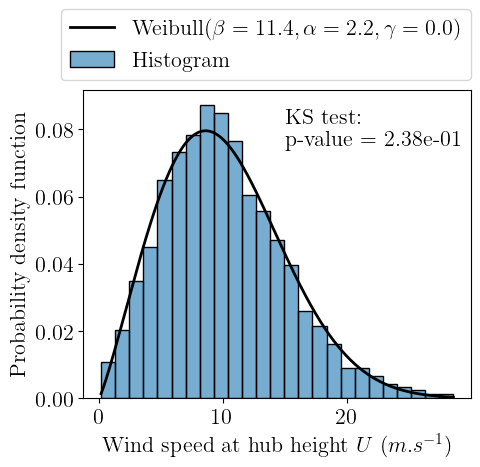

In [9]:
serie = data["U_hub (m/s)"].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_ws.computePDF(xplot)
params = fitted_ws.getParameter()
#
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Weibull($\\beta={params[0]:.1f}, \\alpha={params[1]:.1f}, \\gamma={params[2]:.1f}$)')
sns.histplot(data=data, x="U_hub (m/s)", bins=25, stat="density", alpha=0.6, label='Histogram')
plt.text(15, 0.075, f'KS test: \np-value = {KS_results.getPValue():.2e}')
plt.xlabel('Wind speed at hub height $U$ ($m.s^{-1}$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/free_wsp_distribution_SB.png", bbox_inches='tight', dpi=300);

### Wind direction

In [10]:
kernel = ot.KernelSmoothing()
kernel.setBoundaryCorrection(True)
kernel.setLowerBound(0.)
kernel.setUpperBound(360.)
# Different bandwidth computation 
# (see: http://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html)
silverman_kw = kernel.computeSilvermanBandwidth(sample_wd[:1000])
mixed_kw = kernel.computeMixedBandwidth(sample_wd[:1000])
plugin_kw = kernel.computePluginBandwidth(sample_wd[:1000])
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
wd_kde = kernel.build(sample_wd, mixed_kw)
wd_kde = ot.TruncatedDistribution(wd_kde, 0., 360.)

Silverman bandwidth = 31.01
Mixed bandwidth = 19.08
Plugin bandwidth = 14.97


WRN - Warning! The distribution number 21 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=7.28961e-12 with respect to the maximum weight=7.28961. It is removed from the collection.
WRN - Warning! The distribution number 22 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=7.28961e-12 with respect to the maximum weight=7.28961. It is removed from the collection.
WRN - Warning! The distribution number 50 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=7.28961e-12 with respect to the maximum weight=7.28961. It is removed from the collection.
WRN - Warning! The distribution number 79 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=7.28961e-12 with respect to the maximum weight=7.28961. It is removed from the collection.
WRN - Warning! The distribution number 80 has a too small weight=0 for a relative threshold equal to Mixture-SmallWeight=7.28961e-12 with respect to the

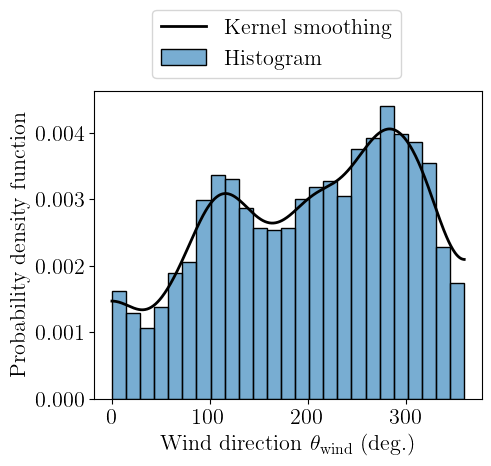

In [11]:
serie = data['θ_wind (deg)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = wd_kde.computePDF(xplot)
#
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Kernel smoothing')
sns.histplot(data=data, x='θ_wind (deg)', bins=25, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wind direction $\\theta_{\\mathrm{wind}}$ (deg.)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/wind_dir_distribution_SB.png", bbox_inches='tight', dpi=300);

### Wave direction

In [12]:
kernel = ot.KernelSmoothing()
kernel.setBoundaryCorrection(True)
kernel.setLowerBound(0.)
kernel.setUpperBound(360.)
# Different bandwidth computation 
# (see: http://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html)
silverman_kw = kernel.computeSilvermanBandwidth(sample_wave_dir[:1000])
mixed_kw = kernel.computeMixedBandwidth(sample_wave_dir[:1000])
plugin_kw = kernel.computePluginBandwidth(sample_wave_dir[:1000])
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
wave_dir_kde = kernel.build(sample_wave_dir[:1000], mixed_kw)
wave_dir_kde = ot.TruncatedDistribution(wave_dir_kde, 0., 360.)

Silverman bandwidth = 7.85
Mixed bandwidth = 7.44
Plugin bandwidth = 7.06


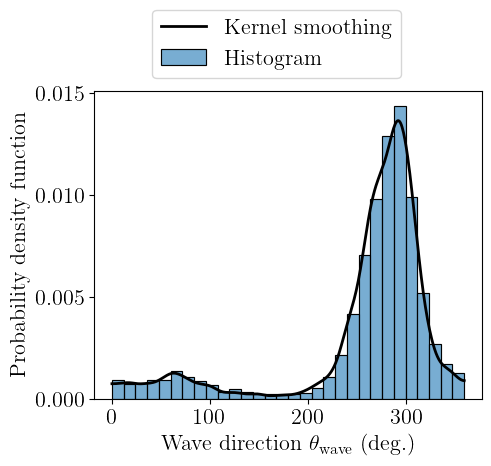

In [13]:
serie = data['θ_wave_new (deg)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = wave_dir_kde.computePDF(xplot)
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Kernel smoothing')
sns.histplot(data=data, x='θ_wave_new (deg)', bins=30, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wave direction $\\theta_{\\mathrm{wave}}$ (deg.)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/wave_dir_distribution_SB.png", bbox_inches='tight', dpi=300);

### Significant wave height - Hs

In [14]:
factory_hs = ot.MaximumLikelihoodFactory(ot.InverseNormal())
# Give bounds for the optimization
lowerBound=[1.0, 1.0]
upperBound=[5.0, 10.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True], [True,True])
factory_hs.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_hs.getOptimizationAlgorithm()
solver.setStartingPoint([3.0, 5.0])
# solve the distribution
fitted_Hs = factory_hs.build(sample_Hs)
print(fitted_Hs)
# BIC
print(f"BIC = {ot.FittingTest.BIC(sample_Hs, fitted_Hs):.3f}")
# KS testing
KS_results = ot.FittingTest.Kolmogorov(sample_Hs, fitted_Hs)
print(KS_results)

InverseNormal(mu = 2.34478, lambda = 6.7603)
BIC = 3.028
class=TestResult name=Unnamed type=Kolmogorov InverseNormal binaryQualityMeasure=true p-value threshold=0.05 p-value=0.532622 statistic=0.0113811 description=[InverseNormal(mu = 2.34478, lambda = 6.7603) vs sample Unnamed]


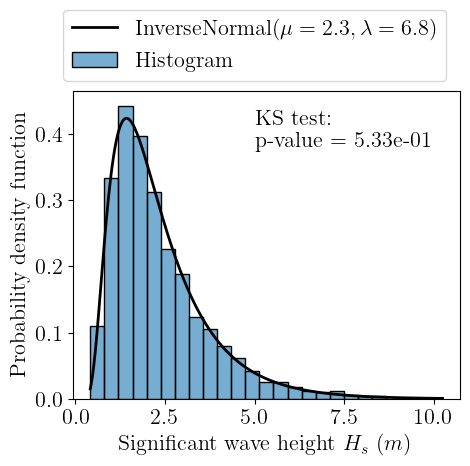

In [15]:
serie = data['Hs (m)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_Hs.computePDF(xplot)
params = fitted_Hs.getParameter()
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'InverseNormal($\\mu={params[0]:.1f}, \\lambda={params[1]:.1f}$)')
sns.histplot(data=data, x='Hs (m)', bins=25, stat="density", alpha=0.6, label='Histogram')
plt.text(5, 0.38, f'KS test: \np-value = {KS_results.getPValue():.2e}')
plt.xlabel('Significant wave height $H_s$ ($m$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/Hs_distribution_SB.png", bbox_inches='tight', dpi=300);

### Wave period - Tp

In [16]:
kernel = ot.KernelSmoothing()
silverman_kw = kernel.computeSilvermanBandwidth(sample_Tp[:1000])
mixed_kw = kernel.computeMixedBandwidth(sample_Tp[:1000])
plugin_kw = kernel.computePluginBandwidth(sample_Tp[:1000])
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
fitted_Tp = kernel.build(sample_Tp[:1000], silverman_kw)

Silverman bandwidth = 0.75
Mixed bandwidth = 0.75
Plugin bandwidth = 0.77


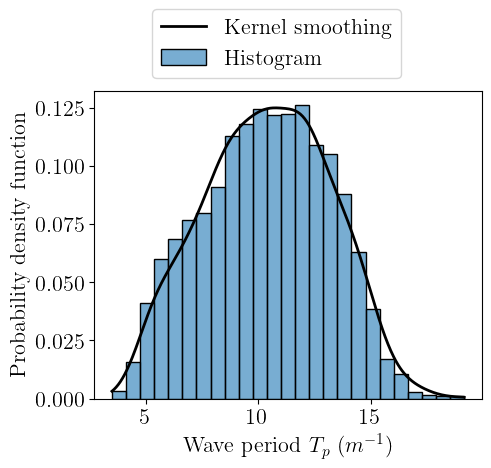

In [17]:
serie = data['Tp (s)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_Tp.computePDF(xplot)
params = fitted_Tp.getParameter()
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label="Kernel smoothing")
sns.histplot(data=data, x='Tp (s)', bins=25, stat="density", alpha=0.6, label='Histogram',zorder=0)
plt.xlabel('Wave period $T_p$ ($m^{-1}$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/Tp_distribution_SB.png", bbox_inches='tight', dpi=300);

## Copula inference

In [18]:
marginals = [wd_kde, fitted_ws, wave_dir_kde, fitted_Hs, fitted_Tp]
def estimate_hybrid_model(m):
    copula = ot.BernsteinCopulaFactory().build(sample, int(m))
    return ot.ComposedDistribution(marginals, copula)

## MMD-based multivariate goodness-of-fit 

In [19]:
m_list = [5, 10, 20, 50, 100, 1000]
ebc_mmd = pd.DataFrame([], columns=m_list, index=np.arange(100))

In [20]:
val_data = pd.read_csv("./data/wind_waves_ANEMOC_1H.csv", index_col=0)
val_data = val_data.iloc[N:2*N]
# usually the convention considers 0° for wind blowing to the north
# the convention adopted by Erik and in farmshadow is different 
# to plot correctly on the wind rose need to define a new wind direction 
val_data['θ_wind (deg)'] = np.mod(val_data['θ_wind (deg)'] - 90, 360)
val_data['θ_wave_new (deg)'] = np.mod(val_data['θ_wave_new (deg)'] - 90, 360)
validation_sample = ot.Sample(np.array(val_data.values))
validation_sample.setDescription(val_data.columns)

In [21]:
# Kernel definition
ker_list = [ot.MaternModel([3.], [1.0], 2.5)] * 5
kernel = ot.ProductCovarianceModel(ker_list)
# Compute MMD 
#initial_energy = np.array(kernel.discretize(sample)).mean()
initial_energy = np.array(kernel.discretize(validation_sample)).mean()
for m in ebc_mmd.columns.values: 
    joint_dist = estimate_hybrid_model(m)
    for i in ebc_mmd.index : 
        ot.RandomGenerator.SetSeed(i+200)
        mc_sample = joint_dist.getSample(1000)
        perturbed_energy = np.array(kernel.discretize(mc_sample)).mean()
        cross_energy = np.array(kernel.computeCrossCovariance(validation_sample, mc_sample)).mean()
        biaised_mmd2 = initial_energy + perturbed_energy - 2 * cross_energy
        ebc_mmd.loc[i, m] = biaised_mmd2
ebc_mmd

,5,10,20,50,100,1000
0,0.001376,0.001323,0.001302,0.001276,0.001245,0.00128
1,0.001403,0.001327,0.001259,0.001257,0.001275,0.001287
2,0.001427,0.001334,0.001278,0.001258,0.001265,0.001262
3,0.001384,0.001363,0.001309,0.001257,0.001251,0.001271
4,0.001407,0.001333,0.001295,0.001263,0.001299,0.001278
...,...,...,...,...,...,...
95,0.001401,0.001328,0.001295,0.001263,0.001246,0.001272
96,0.001416,0.001355,0.001282,0.001248,0.001252,0.00125
97,0.001375,0.001342,0.001283,0.001259,0.001254,0.001272
98,0.001406,0.001302,0.001301,0.001295,0.001256,0.001277


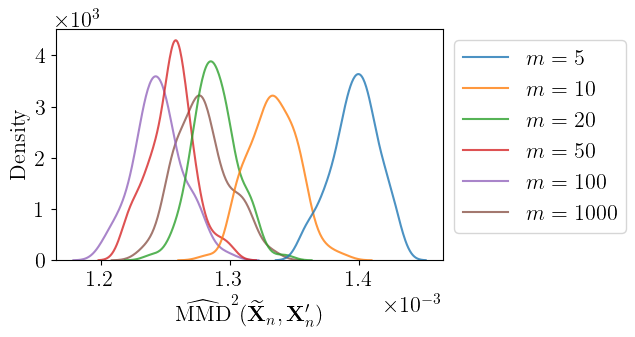

In [27]:
ebc_mmd.columns = ['$m=5$', '$m=10$', '$m=20$', '$m=50$', '$m=100$', '$m=1000$']
plt.figure(figsize=(5, 3))
ax = sns.kdeplot(ebc_mmd, alpha=0.8)
ax.set_xlabel("$\\widehat{\\mathrm{MMD}}^2(\\widetilde{\\mathbf{X}}_n, \\mathbf{X}_n')$")
sns.move_legend(ax, bbox_to_anchor=(1.5, 1.), loc='upper right', ncol=1, columnspacing=1.2)
plt.savefig("figures/SB_MMD_goodness.png", bbox_inches='tight', dpi=300);

## Copulograms

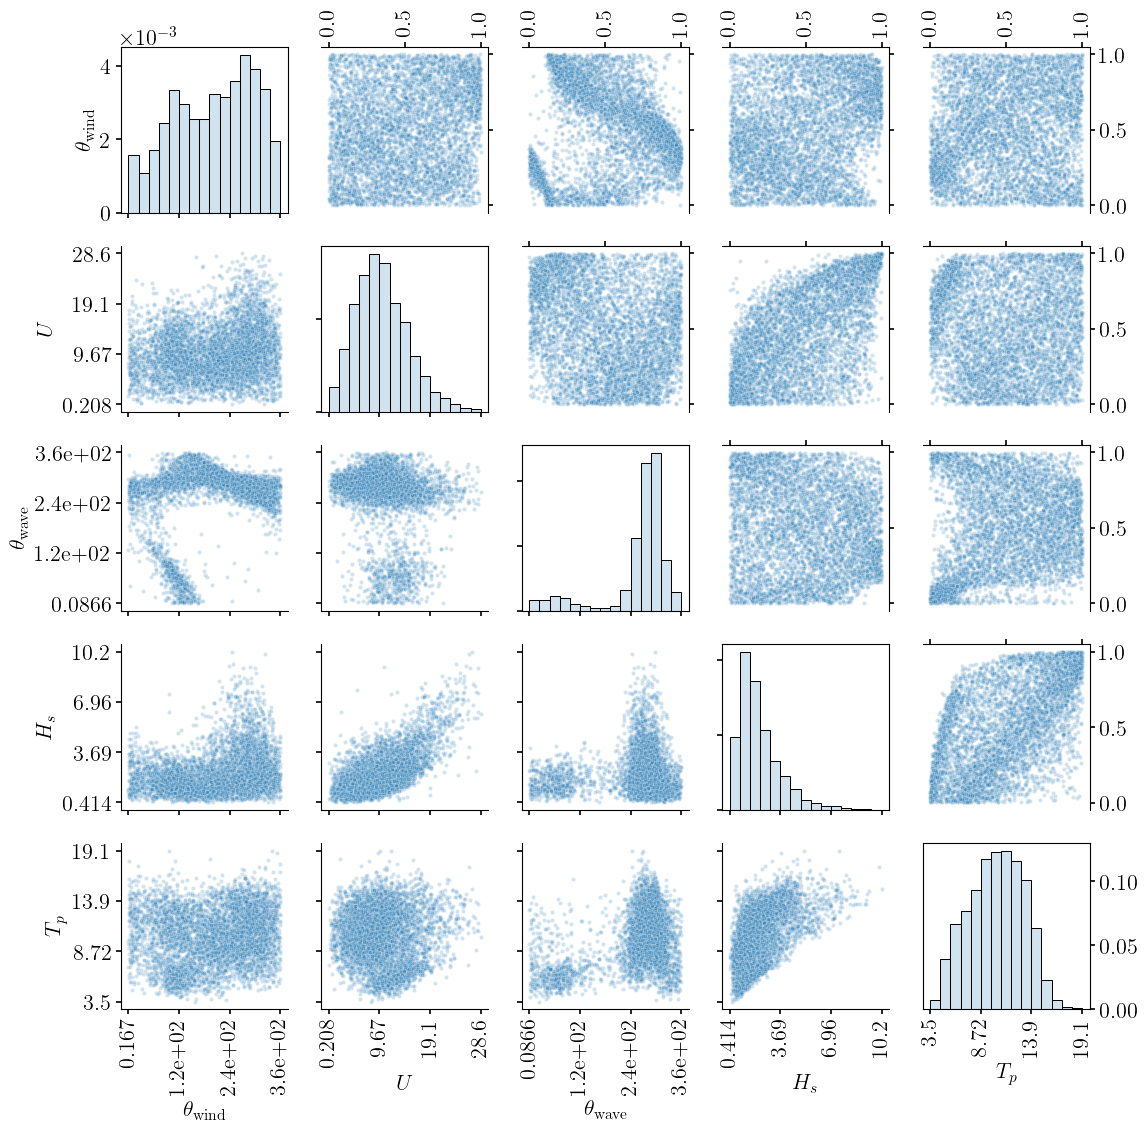

In [23]:
# Learning set
data.columns = ['$\\theta_{\\mathrm{wind}}$', '$U$', '$\\theta_{\\mathrm{wave}}$', '$H_s$', '$T_p$']
copulogram = cp.Copulogram(data)
copulogram.draw(color='C0', marker='.', alpha=0.2)
plt.savefig("figures/SB_data_copulogram.png", bbox_inches='tight', dpi=300);

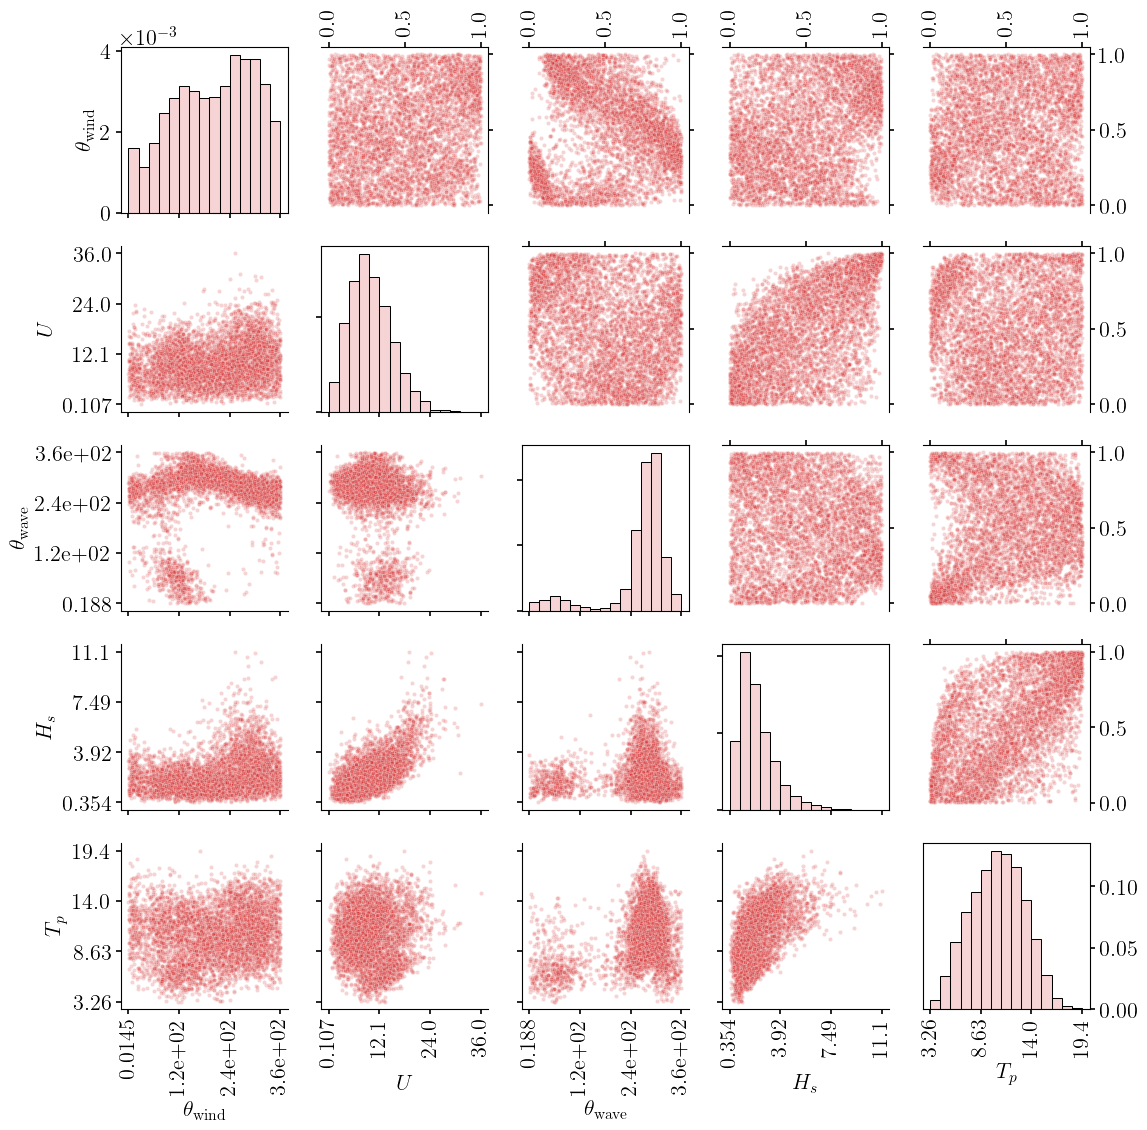

In [24]:
m = 100
joint_dist = estimate_hybrid_model(m)
ebc_mc_sample = joint_dist.getSample(5000)
ebc_data = pd.DataFrame(np.array(ebc_mc_sample), columns=data.columns)
copulogram = cp.Copulogram(ebc_data)
copulogram.draw(color='C3', marker='.', alpha=0.2)
plt.savefig("figures/SB_EBC_copulogram.png", bbox_inches='tight', dpi=300);